In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
base='/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir=os.path.join(base,'train')
valid_dir=os.path.join(base,'test')

In [3]:
from os import listdir
from os.path import isfile, join
train_list = {}
length=[]
for f in listdir(train_dir):
    new_path=os.path.join(train_dir,f)
    train_list[f]=[]
    for m in listdir(new_path):
        train_list[f].append(os.path.join(new_path,m))
    length.append(len(train_list[f]))

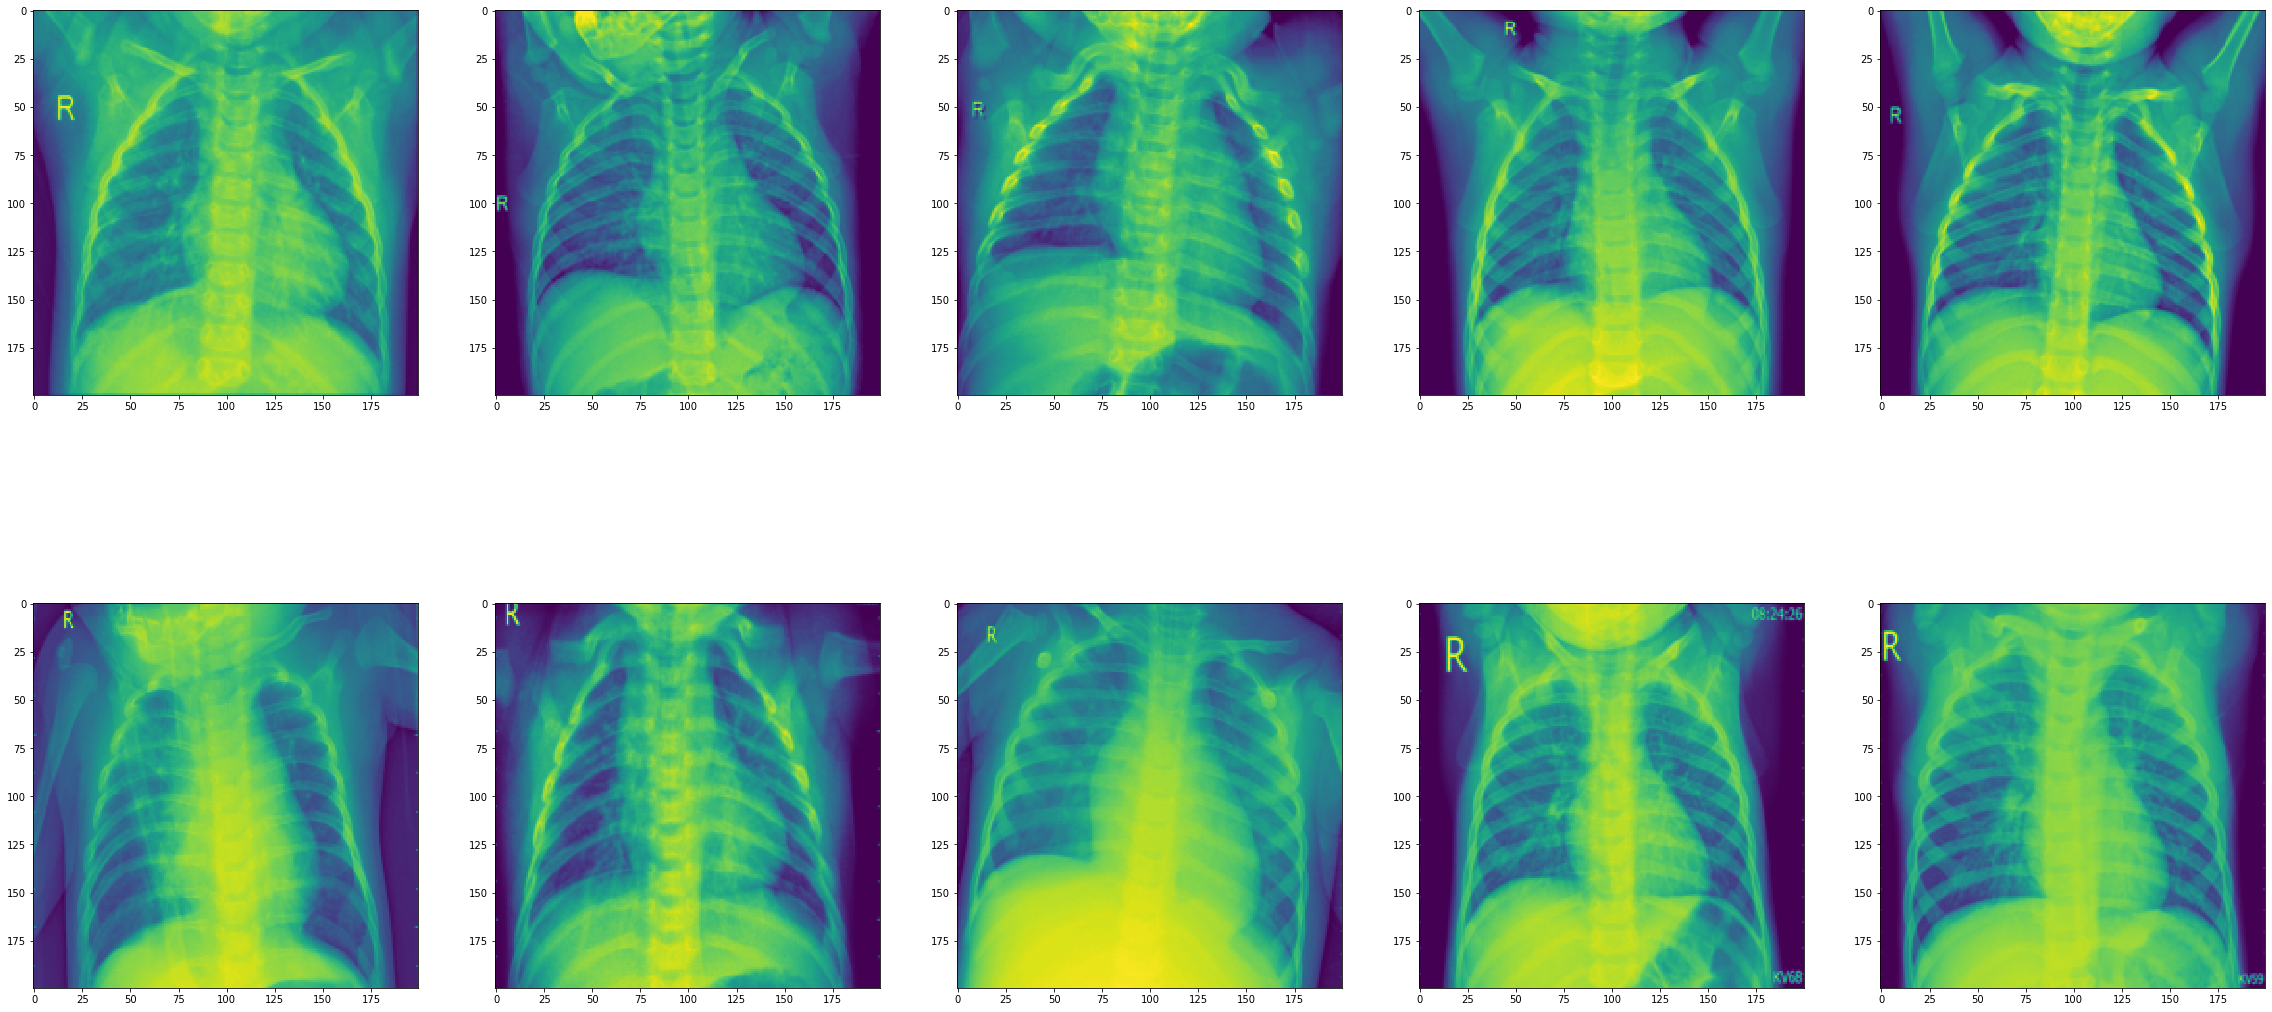

In [4]:
from skimage.transform import resize
import matplotlib.pyplot as plt
from matplotlib import image
fig,ax=plt.subplots(2,5,figsize=[40,20])
rn=np.random.randint(500,size=5)
keys=[a for a in train_list.keys()]
for i in range(2):
    for j in range(5):
        img=image.imread(train_list[keys[i]][rn[j]])
        img=resize(img,[200,200])
        ax[i,j].imshow(img)

In [22]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
def myFunc(image):
    image = np.array(image)
    converted_img=image/image.max()*255.0
    return converted_img
train_data=ImageDataGenerator(rescale=1/255.,
                              rotation_range=5,
                              zoom_range=0.2,
                              shear_range=0.2,
                              preprocessing_function=myFunc)
valid_data=ImageDataGenerator(rescale=1/255.,preprocessing_function=myFunc)

train_generator = train_data.flow_from_directory(train_dir,
                                                 target_size=(128, 128),
                                                 color_mode="grayscale",
                                                 batch_size=32,
                                                 class_mode='binary')

valid_generator = valid_data.flow_from_directory(valid_dir,
                                                 target_size=(128, 128),
                                                 color_mode="grayscale",
                                                 batch_size=32,
                                                 class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


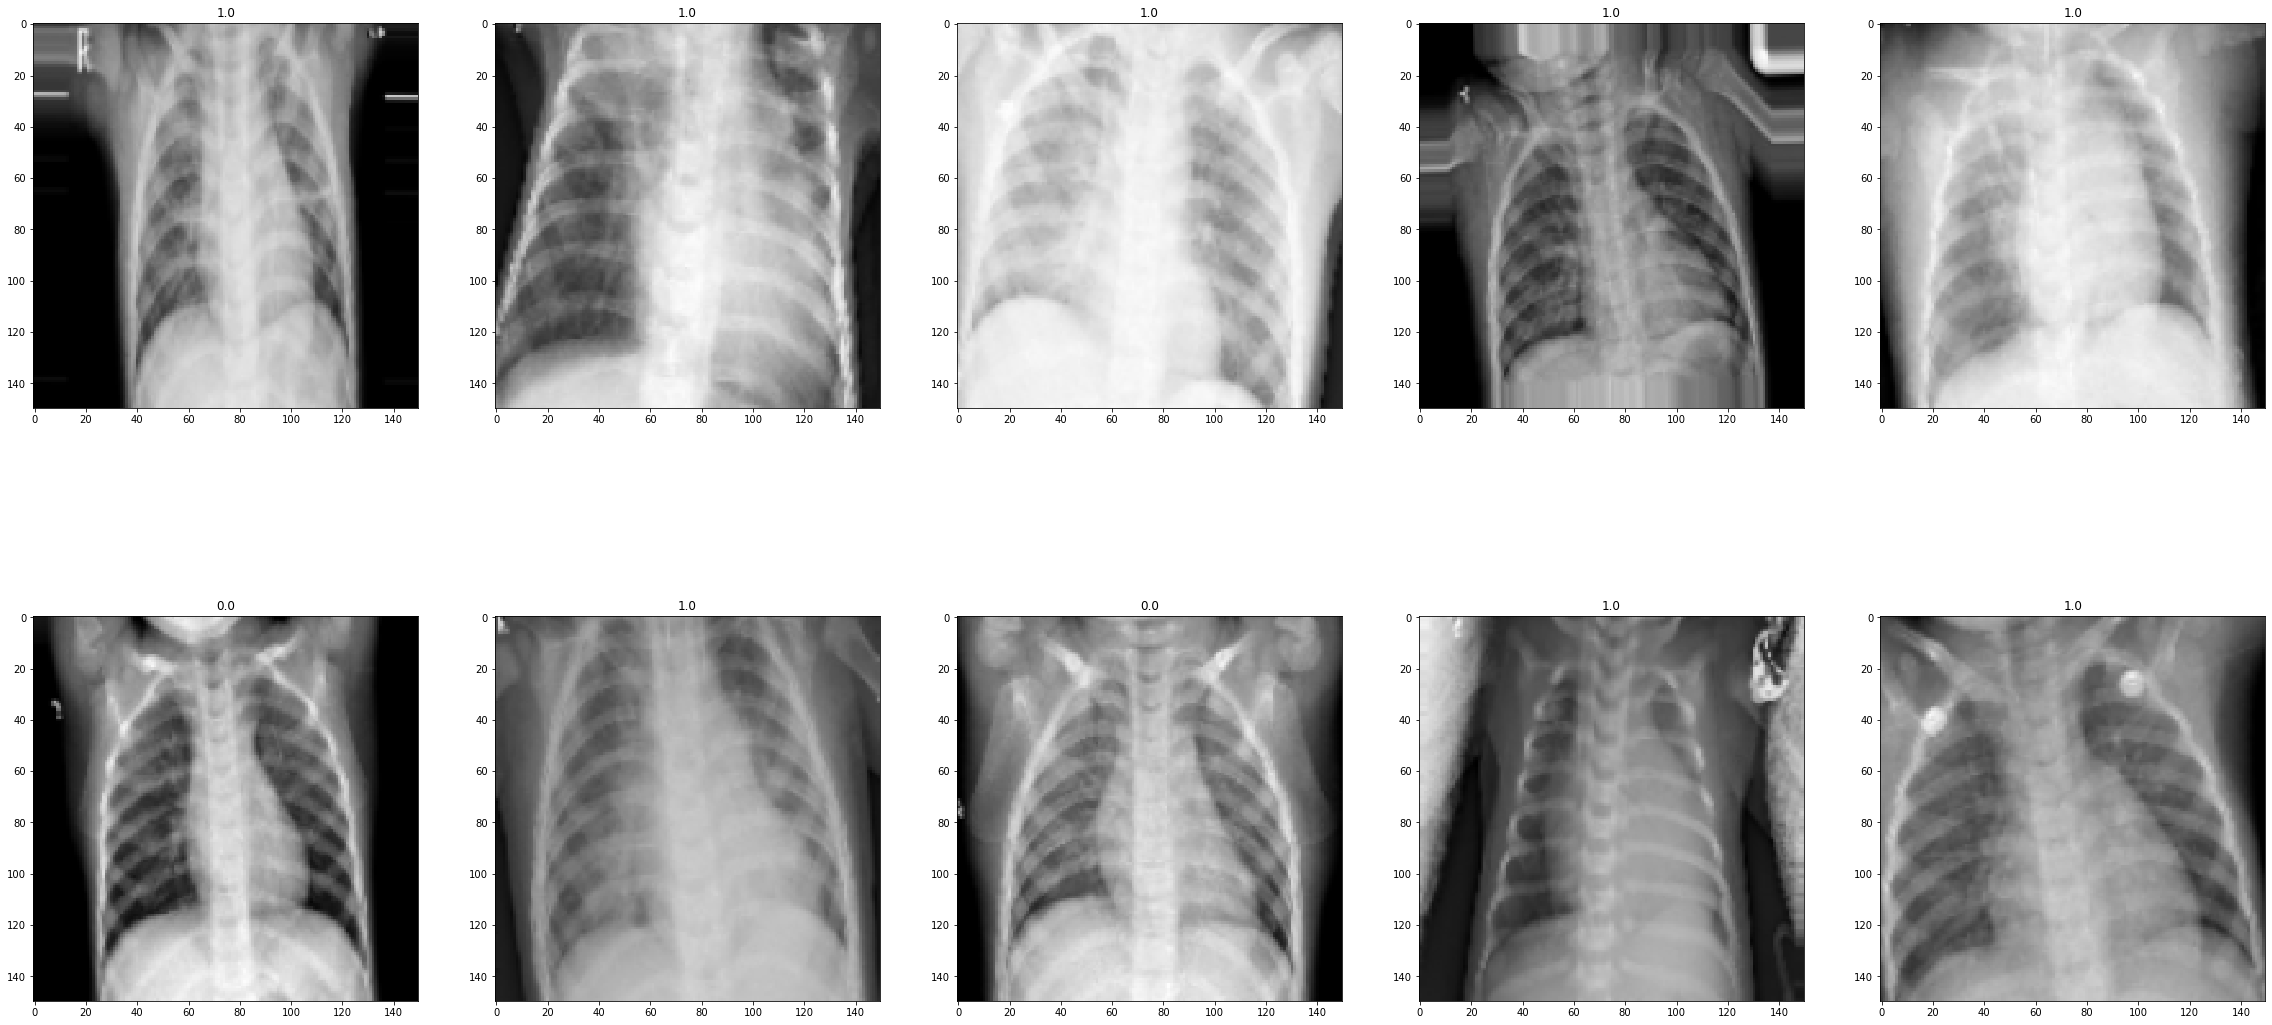

In [23]:
# Plot Data Batches
x_batch,y_batch=next(train_generator)
fig,ax=plt.subplots(2,5,figsize=[40,20])
for i in range(2):
    for j in range(5):
        img=x_batch[5*i+j]*255.0
        img=img.astype('uint8')
        img=resize(img,[150,150,3])
        ax[i,j].imshow(img)
        ax[i,j].set_title(y_batch[5*i+j])

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.layers import MaxPool2D, Dropout
from tensorflow.keras.layers import AvgPool2D
from tensorflow.keras.layers import BatchNormalization


In [26]:
tf.keras.backend.clear_session()
x_input=Input([128,128,1])
x=Conv2D(32,(3,3),activation='relu')(x_input)
x=BatchNormalization()(x)
x=MaxPool2D(2,2)(x)
x=Conv2D(64,(3,3),activation='relu')(x)
x=BatchNormalization()(x)
x=MaxPool2D(2,2)(x)
x=Conv2D(128,(3,3),activation='relu')(x)
x=BatchNormalization()(x)
x=AvgPool2D(2,2)(x)
x=Flatten()(x)
x=Dense(1024,activation='relu')(x)
x=BatchNormalization()(x)
x=Dropout(0.2)(x)
x=Dense(1,activation='sigmoid')(x)
model=Model(x_input,x)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0     

In [20]:
## Create Custom CallBacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('accuracy')>0.97) and (logs.get('val_accuracy')<0.80):
            print('\nModel is overfitting hence stopped training')
            self.model.stop_training=True
        if(logs.get('accuracy')>0.98) and (logs.get('val_accuracy')>0.98):
            print('\nModel is accurate hence stopped training')
            self.model.stop_training=True
        
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)
callbacks=[myCallback(),early_stopping]

In [27]:
history=model.fit(train_generator,
                  validation_data=valid_generator,
                  epochs=50,
                  steps_per_epoch=50,
                  validation_steps=10,
                  callbacks=callbacks)

Train for 100 steps, validate for 10 steps
Epoch 1/50
100/100 [==============================] - 94s 938ms/step - loss: 0.4024 - accuracy: 0.8903 - val_loss: 3.3384 - val_accuracy: 0.6156
Epoch 2/50
100/100 [==============================] - 92s 917ms/step - loss: 0.1956 - accuracy: 0.9269 - val_loss: 2.3221 - val_accuracy: 0.6156
Epoch 3/50
100/100 [==============================] - 90s 896ms/step - loss: 0.1804 - accuracy: 0.9337 - val_loss: 4.7096 - val_accuracy: 0.6156
Epoch 4/50
100/100 [==============================] - 89s 894ms/step - loss: 0.1556 - accuracy: 0.9441 - val_loss: 5.0372 - val_accuracy: 0.6156
Epoch 5/50
100/100 [==============================] - 90s 899ms/step - loss: 0.1352 - accuracy: 0.9503 - val_loss: 0.3065 - val_accuracy: 0.8844
Epoch 6/50
100/100 [==============================] - 91s 914ms/step - loss: 0.1398 - accuracy: 0.9503 - val_loss: 1.0256 - val_accuracy: 0.6281
Epoch 7/50
100/100 [==============================] - 89s 893ms/step - loss: 0.1371 - a